In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import numpy as np
from kernels import HMC_vanilla, HMC_our, Reverse_kernel

%matplotlib inline

import random

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

In [2]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

set_seeds(1)

In [3]:
class Encoder_vae(nn.Module):
    def __init__(self, data_dim, z_dim, K=8):
        super(Encoder_vae, self).__init__()
        self.h1 = nn.Linear(in_features=data_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

# Notebook with simple experiments

## Task 1

### Receiving of the true $\theta$ and generating of a dataset

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

z_dim = 2 # Latent space dimensionality
data_dim = 10 # Data dimensionality
N = 10000 # Dataset size
N_val = 1000 # Validation Dataset

sigma_0 = 1. # True std

In [5]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
std_normal_pyro = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
true_theta = std_normal.sample((z_dim, data_dim)) * sigma_0
print('True decoder matrix')
print(true_theta)
print('-' * 100)

data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()

data_probs_val = torch.sigmoid(std_normal.sample((N_val, z_dim)) @ true_theta)
data_val = torch.distributions.Bernoulli(probs=data_probs_val).sample()

print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
Generated data example:
tensor([[1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 1., 0., 0., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 0., 0., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0., 1., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1., 1.]], device='cuda:0')


In [6]:
print('!!!!!')
previous_theta = torch.tensor([[-0.296278  ,  2.676448  , -0.1408463 , -0.84409505,  0.29053846,
        -0.28383088, -1.4534557 ,  2.3736813 , -0.01774164, -2.7884495 ],
       [-0.37882465,  0.7045725 , -1.3956138 , -0.12478404, -0.9258568 ,
        -1.5463208 , -0.49016267,  0.02436782, -1.5992415 , -0.8468648 ]], dtype=torch.float32, device=device)
assert(np.abs(previous_theta.cpu().numpy() - true_theta.cpu().numpy()) < 1e-8).all()
print('OK!')

!!!!!
OK!


## Task 2

### Sample z with target $p(z|x)$, using NUTS

#### 1) Bernoulli likelihood from torch

In [7]:
n_warmup = 20000
n_samples = 1000

data_ind = 0  #  index of datapoint we conditioned on

In [8]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [9]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 21000/21000 [02:05, 167.54it/s, step size=8.49e-01, acc. prob=0.900]


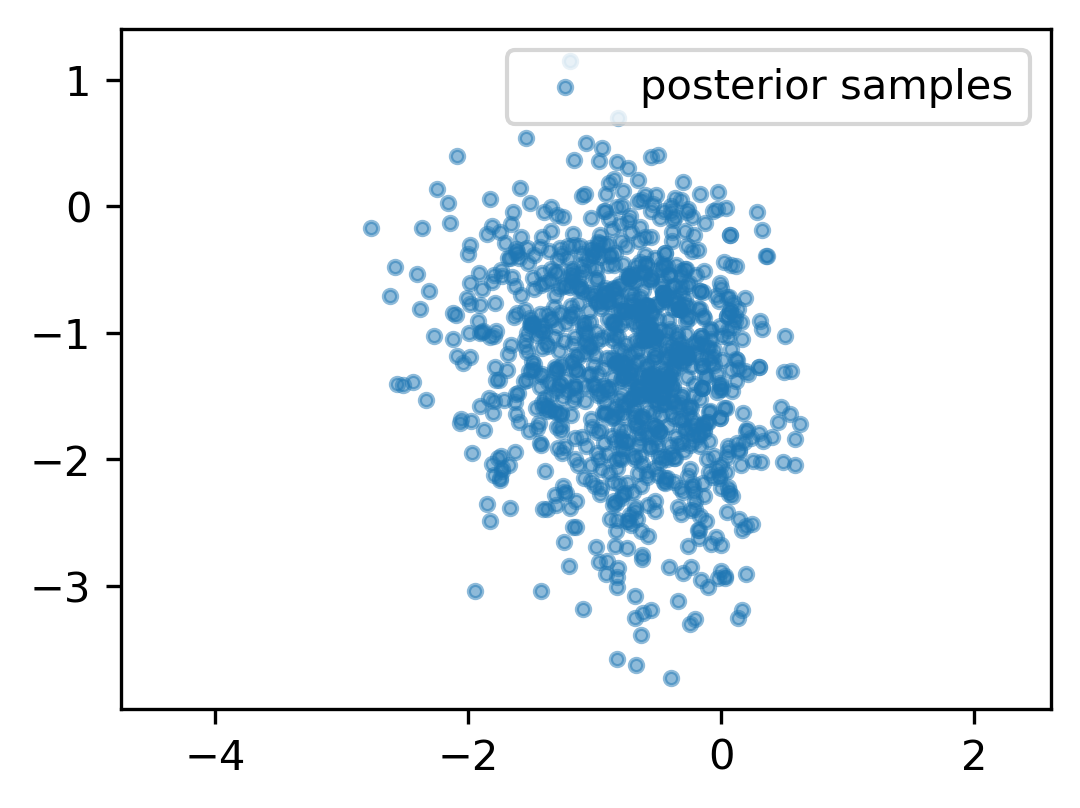

In [10]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

### Sample z with target $p(z|x)$, using our HMC

In [7]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict({})

args.device = device

args.N = 5

args.alpha = 0.5
args.use_partialref = False

args.gamma = 0.1
args.use_barker = False

In [8]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(z @ true_theta)
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [13]:
transitions = HMC_vanilla(args)
z = std_normal.sample((1, z_dim))
momentum = std_normal.sample(z.shape)

print('Warm up')
for i in tqdm(range(n_warmup)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    
print('Sampling')
samples = []
for i in tqdm(range(n_samples)):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=data[data_ind][None])
    samples.append(z.cpu().detach().numpy())

  0%|          | 16/20000 [00:00<02:12, 150.58it/s]

Warm up


  2%|▏         | 16/1000 [00:00<00:06, 151.57it/s]

Sampling


100%|██████████| 1000/1000 [00:06<00:00, 150.42it/s]


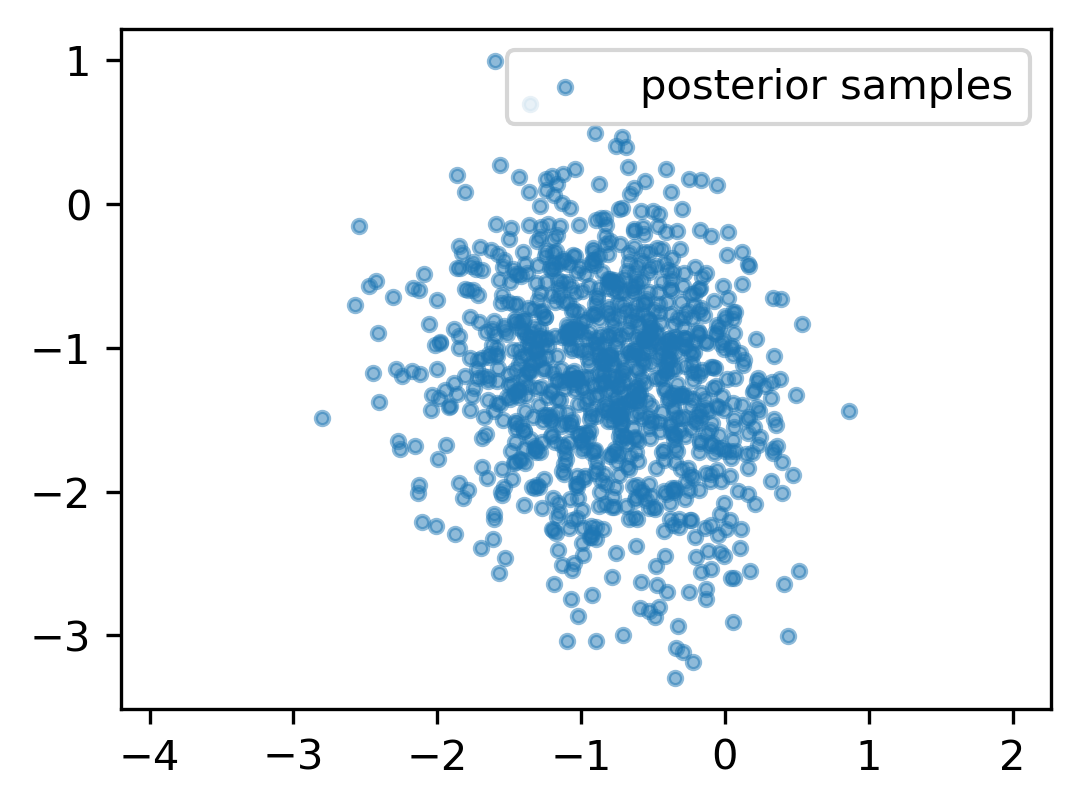

In [14]:
samples = np.array(samples).squeeze()

plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(samples[:, 0], samples[:, 1], label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

## Task 3

#### Fisher's identity, NUTS

In [9]:
num_epoches = 10
batch_size = 1
n_samples = 10
n_warmup = 25

print_info_ = 1

In [10]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [13]:
# dec_nuts = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
# optimizer = torch.optim.Adam(params=dec_nuts.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

In [14]:
# def potential_fn(z):
#     z = z['points']
#     probs = torch.sigmoid(z @ current_matrix)
#     return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [19]:
# for ep in tqdm(range(num_epoches)): # cycle over epoches
#     plt.close()
#     j = 0
#     obj_sum = 0
#     for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
#         init_samples = std_normal.sample((batch_train.shape[0], z_dim))
#         init_params = {'points': init_samples}
        
#         current_matrix = dec_nuts.W.weight.detach().T
        
#         nuts_kernel = NUTS(potential_fn=potential_fn)
#         mcmc = MCMC(nuts_kernel,
#                     initial_params=init_params,
#                     num_samples=n_samples,
#                     warmup_steps=n_warmup,
#                    disable_progbar=True)
#         mcmc.run()
#         z = mcmc.get_samples()['points'][-n_samples:].squeeze(1)
        
# #         pdb.set_trace()
        
#         probs = torch.sigmoid(dec_nuts(z))
#         obj = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()

#         (-obj).backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         j += 1
#         obj_sum += obj.cpu().detach().numpy()
# #     scheduler.step(obj)
#     obj_sum /= j
#     if ep % print_info_ == 0:
#         print('obj mean over epoch:', obj_sum)
#         print('obj:', obj.cpu().detach().item())

In [20]:
# print('true_theta', true_theta)
# print('-' * 100)
# print(dec_nuts.W.weight.detach().T)

#### Fisher's identity, our HMC

In [11]:
num_epoches = 100
batch_size = 200

print_info_ = 5

K_wu = 70
K_s = 30
args.N = 2

In [12]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [15]:
dec_our_hmc_fisher = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(params=dec_our_hmc_fisher.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

transitions = HMC_vanilla(args)

In [16]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(dec_our_hmc_fisher(z))
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [25]:
for ep in tqdm(range(num_epoches)): # cycle over epoches
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
        momentum = std_normal.sample((batch_train.shape[0], z_dim))
        z = std_normal.sample((batch_train.shape[0], z_dim))

#         pdb.set_trace()
        for _ in range(K_wu):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            
        obj = 0
        for _ in range(K_s):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            probs = torch.sigmoid(dec_our_hmc_fisher(z))
            obj += torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
            
        obj /= K_s 

        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
    scheduler.step(obj)
    obj_sum /= j
    if ep % print_info_ == 0:
        print('obj mean over epoch:', obj_sum)
        print('obj:', obj.cpu().detach().item())
        print(dec_our_hmc_fisher.W.weight.detach().T)

  1%|          | 1/100 [00:21<35:48, 21.70s/it]

obj mean over epoch: -0.6639611458778382
obj: -0.6650576591491699
tensor([[-0.2204, -0.1672, -0.1812,  0.4571, -0.6451,  0.2160,  0.5137, -0.7145,
          0.5728,  0.3522],
        [-0.3948, -0.2687,  0.0681,  0.3505,  0.4267,  0.6359, -0.5981, -0.2986,
         -0.0790, -0.2877]], device='cuda:0')


  6%|▌         | 6/100 [02:09<33:50, 21.61s/it]

obj mean over epoch: -0.6348888170719147
obj: -0.6394892334938049
tensor([[ 0.0059, -0.4184,  0.0367,  0.6322, -0.4279,  0.3253,  0.7473, -0.9450,
          0.3985,  0.6004],
        [-0.2056, -0.1438,  0.2331,  0.2182,  0.4669,  0.5634, -0.3920, -0.1259,
          0.1391, -0.1010]], device='cuda:0')


 11%|█         | 11/100 [03:58<32:11, 21.71s/it]

obj mean over epoch: -0.6032061970233917
obj: -0.5767140984535217
tensor([[ 0.1858, -0.6540,  0.2053,  0.7399, -0.2397,  0.4247,  0.9553, -1.1576,
          0.3248,  0.8346],
        [-0.0038, -0.1208,  0.4545,  0.1223,  0.6007,  0.6666, -0.2180,  0.0072,
          0.3671,  0.0404]], device='cuda:0')


 16%|█▌        | 16/100 [05:46<30:14, 21.60s/it]

obj mean over epoch: -0.5801374566555023
obj: -0.5680239796638489
tensor([[ 0.2796, -0.8555,  0.3042,  0.7844, -0.1378,  0.4513,  1.1139, -1.3305,
          0.3068,  1.0357],
        [ 0.1322, -0.0869,  0.6496,  0.0406,  0.7510,  0.8399, -0.0934,  0.1407,
          0.5821,  0.1161]], device='cuda:0')


 21%|██        | 21/100 [07:35<28:43, 21.82s/it]

obj mean over epoch: -0.5608962750434876
obj: -0.5594804286956787
tensor([[ 0.3367, -1.0339,  0.3474,  0.8069, -0.1016,  0.4795,  1.2303, -1.4833,
          0.3028,  1.2146],
        [ 0.2286, -0.0715,  0.8255, -0.0392,  0.8613,  1.0142, -0.0077,  0.2367,
          0.7727,  0.1388]], device='cuda:0')


 26%|██▌       | 26/100 [09:25<27:06, 21.98s/it]

obj mean over epoch: -0.5505064606666565
obj: -0.5500346422195435
tensor([[ 0.3557, -1.1940,  0.3830,  0.8145, -0.0908,  0.4958,  1.3223, -1.6062,
          0.3135,  1.3675],
        [ 0.3043, -0.0577,  0.9515, -0.0885,  0.9228,  1.1402,  0.0505,  0.3200,
          0.9336,  0.1231]], device='cuda:0')


 31%|███       | 31/100 [11:14<25:11, 21.91s/it]

obj mean over epoch: -0.5428840792179108
obj: -0.5506240129470825
tensor([[ 0.3596, -1.3373,  0.3973,  0.8232, -0.0847,  0.5147,  1.3908, -1.7265,
          0.3072,  1.5104],
        [ 0.3323, -0.0445,  1.0566, -0.0945,  0.9572,  1.2326,  0.0716,  0.3770,
          1.0634,  0.1472]], device='cuda:0')


 36%|███▌      | 36/100 [13:04<23:19, 21.87s/it]

obj mean over epoch: -0.5365270900726319
obj: -0.5364713668823242
tensor([[ 0.3559, -1.4665,  0.4134,  0.8266, -0.0936,  0.5373,  1.4388, -1.8337,
          0.3265,  1.6372],
        [ 0.3417, -0.0501,  1.1493, -0.1000,  0.9704,  1.3009,  0.0900,  0.4097,
          1.1675,  0.1509]], device='cuda:0')


 41%|████      | 41/100 [14:52<21:18, 21.67s/it]

obj mean over epoch: -0.5333943164348602
obj: -0.521647572517395
tensor([[ 0.3565, -1.5930,  0.4255,  0.8348, -0.0930,  0.5492,  1.4624, -1.9108,
          0.3348,  1.7568],
        [ 0.3524, -0.0396,  1.2183, -0.0995,  0.9707,  1.3554,  0.1069,  0.4348,
          1.2494,  0.1571]], device='cuda:0')


 46%|████▌     | 46/100 [16:41<19:40, 21.86s/it]

obj mean over epoch: -0.529369215965271
obj: -0.5327000617980957
tensor([[ 0.3572, -1.7054,  0.4316,  0.8422, -0.0941,  0.5622,  1.4877, -1.9888,
          0.3359,  1.8673],
        [ 0.3650, -0.0429,  1.2645, -0.0951,  0.9582,  1.4017,  0.1181,  0.4753,
          1.3083,  0.1548]], device='cuda:0')


 51%|█████     | 51/100 [18:26<17:16, 21.16s/it]

obj mean over epoch: -0.525317280292511
obj: -0.5263804197311401
tensor([[ 0.3609, -1.8087,  0.4409,  0.8264, -0.0863,  0.5724,  1.4996, -2.0520,
          0.3458,  1.9724],
        [ 0.3611, -0.0343,  1.2962, -0.0964,  0.9665,  1.4198,  0.1184,  0.5009,
          1.3670,  0.1468]], device='cuda:0')


 56%|█████▌    | 56/100 [20:14<15:47, 21.54s/it]

obj mean over epoch: -0.5255551242828369
obj: -0.5478469729423523
tensor([[ 0.3707, -1.9103,  0.4591,  0.8263, -0.0858,  0.5829,  1.5065, -2.1071,
          0.3581,  2.0631],
        [ 0.3610, -0.0315,  1.3199, -0.0927,  0.9647,  1.4353,  0.1263,  0.5207,
          1.3975,  0.1404]], device='cuda:0')


 61%|██████    | 61/100 [22:01<13:53, 21.37s/it]

obj mean over epoch: -0.5237181413173676
obj: -0.523196816444397
tensor([[ 0.3689, -2.0034,  0.4603,  0.8244, -0.0783,  0.5872,  1.5085, -2.1640,
          0.3693,  2.1516],
        [ 0.3585, -0.0183,  1.3281, -0.0752,  0.9633,  1.4488,  0.1381,  0.5359,
          1.4429,  0.1445]], device='cuda:0')


 66%|██████▌   | 66/100 [23:49<12:14, 21.60s/it]

obj mean over epoch: -0.5217935329675675
obj: -0.541688859462738
tensor([[ 0.3656, -2.0902,  0.4603,  0.8260, -0.0826,  0.5974,  1.5093, -2.2066,
          0.3711,  2.2358],
        [ 0.3589, -0.0148,  1.3332, -0.0918,  0.9774,  1.4686,  0.1293,  0.5515,
          1.4793,  0.1549]], device='cuda:0')


 71%|███████   | 71/100 [25:38<10:32, 21.82s/it]

obj mean over epoch: -0.5217273330688477
obj: -0.5091897249221802
tensor([[ 0.3680, -2.1664,  0.4620,  0.8379, -0.0840,  0.5922,  1.5041, -2.2397,
          0.3570,  2.3136],
        [ 0.3543, -0.0213,  1.3413, -0.0925,  0.9780,  1.4643,  0.1378,  0.5522,
          1.4939,  0.1566]], device='cuda:0')


 76%|███████▌  | 76/100 [27:27<08:43, 21.83s/it]

obj mean over epoch: -0.520965074300766
obj: -0.5244486927986145
tensor([[ 0.3665, -2.2472,  0.4572,  0.8431, -0.0820,  0.5876,  1.5041, -2.2684,
          0.3680,  2.3878],
        [ 0.3545, -0.0254,  1.3418, -0.0877,  0.9820,  1.4567,  0.1388,  0.5572,
          1.5116,  0.1702]], device='cuda:0')


 80%|████████  | 80/100 [28:55<07:18, 21.90s/it]

Epoch    80: reducing learning rate of group 0 to 1.0000e-04.


 81%|████████  | 81/100 [29:17<06:55, 21.89s/it]

obj mean over epoch: -0.5194236701726913
obj: -0.5101088285446167
tensor([[ 0.3666, -2.3053,  0.4516,  0.8427, -0.0832,  0.5929,  1.5037, -2.2650,
          0.3719,  2.4394],
        [ 0.3536, -0.0258,  1.3398, -0.0807,  0.9800,  1.4752,  0.1346,  0.5704,
          1.5213,  0.1604]], device='cuda:0')


 86%|████████▌ | 86/100 [31:05<05:03, 21.71s/it]

obj mean over epoch: -0.519871746301651
obj: -0.5226106643676758
tensor([[ 0.3667, -2.3119,  0.4533,  0.8428, -0.0837,  0.5930,  1.5035, -2.2678,
          0.3701,  2.4461],
        [ 0.3538, -0.0268,  1.3388, -0.0800,  0.9784,  1.4738,  0.1351,  0.5689,
          1.5224,  0.1613]], device='cuda:0')


 91%|█████████ | 91/100 [32:52<03:12, 21.36s/it]

obj mean over epoch: -0.5188726186752319
obj: -0.5346565246582031
tensor([[ 0.3662, -2.3194,  0.4544,  0.8416, -0.0840,  0.5935,  1.5051, -2.2700,
          0.3688,  2.4525],
        [ 0.3539, -0.0282,  1.3382, -0.0793,  0.9765,  1.4738,  0.1340,  0.5684,
          1.5230,  0.1626]], device='cuda:0')


 96%|█████████▌| 96/100 [34:42<01:27, 21.76s/it]

obj mean over epoch: -0.5197654193639756
obj: -0.534059464931488
tensor([[ 0.3667, -2.3265,  0.4559,  0.8406, -0.0841,  0.5934,  1.5049, -2.2725,
          0.3692,  2.4594],
        [ 0.3532, -0.0275,  1.3382, -0.0799,  0.9759,  1.4729,  0.1365,  0.5682,
          1.5254,  0.1631]], device='cuda:0')


100%|██████████| 100/100 [36:10<00:00, 21.70s/it]


In [26]:
print('true_theta', true_theta)
print('-' * 100)
print(dec_our_hmc_fisher.W.weight.detach().T)

true_theta tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[ 0.3666, -2.3329,  0.4573,  0.8417, -0.0834,  0.5933,  1.5054, -2.2738,
          0.3698,  2.4653],
        [ 0.3532, -0.0271,  1.3382, -0.0795,  0.9741,  1.4714,  0.1370,  0.5685,
          1.5270,  0.1658]], device='cuda:0')


In [27]:
for p in dec_our_hmc_fisher.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_our_hmc_fisher(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[6.7111e-01, 1.3951e-02, 7.3158e-01, 8.2129e-01, 4.9265e-01, 7.8032e-01,
         9.4063e-01, 1.6703e-02, 7.0409e-01, 9.8920e-01],
        [2.6128e-01, 6.8282e-01, 2.5098e-02, 4.8961e-01, 7.3111e-02, 1.7107e-02,
         3.0805e-01, 3.0596e-01, 1.5817e-02, 2.3660e-01],
        [3.9451e-01, 5.9986e-01, 1.8655e-01, 4.8682e-01, 2.6801e-01, 1.6330e-01,
         4.0465e-01, 4.4343e-01, 1.6032e-01, 3.6095e-01],
        [4.9959e-01, 1.3448e-01, 3.1889e-01, 6.7854e-01, 2.9136e-01, 3.1835e-01,
         7.5040e-01, 8.9771e-02, 2.7114e-01, 8.6436e-01],
        [4.1618e-01, 8.8939e-01, 3.8935e-01, 3.2097e-01, 5.1106e-01, 3.5993e-01,
         2.0607e-01, 8.8217e-01, 4.0667e-01, 9.9118e-02],
        [4.2526e-01, 8.7882e-01, 4.1351e-01, 3.2795e-01, 5.2481e-01, 3.8671e-01,
         2.1840e-01, 8.7528e-01, 4.3300e-01, 1.1009e-01],
        [2.3947e-01, 9.9916e-01, 1.7516e-01, 7.2728e-02, 5.3391e-01, 1.2148e-01,
         1.0088e-02, 9.9892e-01, 2.1306e-01, 5.5075e-04],
       

## Task 4

### Selecting best annealing coeff

In [13]:
K = 8
num_epoches = 3000
batch_size = 200
print_info_ = 500

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_annealing_all = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec_annealing_all.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [14]:
def run_validation(enc, dec):
    for p in enc.parameters():
        p.requires_grad_(False)
        
    for p in dec.parameters():
        p.requires_grad_(False)
        
    j = 0
    elbo_sum = 0
    for b_num, batch_val in enumerate(dataloader_val):
        mu, sigma = enc(batch_val) # sample mu and sigma from encoder
        u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick

        prod = dec(z)
        log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_val))

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
        
        j += 1
        elbo_sum += elbo.cpu().detach().numpy()
        
    elbo_sum /= j
    for p in enc.parameters():
        p.requires_grad_(True)
        
    for p in dec.parameters():
        p.requires_grad_(True)
    return elbo_sum

In [15]:
def run_training(enc, dec, best_beta=None, annealing_beta=True):
    patience = 100
    patience_current = 0
    
    if annealing_beta:
        beta = torch.linspace(0., 1., 20, device=device)
        beta_ind = 0
        beta_current = beta[beta_ind]
        best_ind = 0
    else:
        beta_current = 1.

    best_elbo = -float('inf')
    iterator = tqdm(range(num_epoches))

    for ep in iterator: # cycle over epoches
        j = 0
        elbo_sum = 0
        for b_num, batch_train in enumerate(dataloader): # cycle over batches
            mu, sigma = enc(batch_train) # sample mu and sigma from encoder
            u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
            z = mu + u * sigma # reperametrization trick

            prod = dec(z)
#             log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train))
            log_likelihood = (batch_train * dec(mu) - torch.log(1+ torch.exp(prod))).sum(1)

            KLD = beta_current * (-0.5) * torch.sum(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2), 1)
            elbo = torch.mean(log_likelihood - KLD)
            
            (-elbo).backward()

            optimizer.step()
            optimizer.zero_grad()

            j += 1
            elbo_sum += elbo.cpu().detach().numpy()

        current_val_elbo = run_validation(enc, dec)
        elbo_sum /= j

        if current_val_elbo > best_elbo:
            patience_current = 0
            best_elbo = current_val_elbo
            if annealing_beta:
                best_ind = beta_ind
        else:
            patience_current += 1
            if patience_current >= patience:
                if annealing_beta:
                    beta_ind = min(beta_ind + 1, beta.shape[0] - 1)
                    if best_beta:
                        beta_current = min(beta[beta_ind], best_beta)
                    else:
                        beta_current = beta[beta_ind]
                    patience_current = 0
                    print('Current beta:', beta_current)
                else:
                    iterator.close()
                    break

    #     scheduler.step(elbo_sum)
        if ep % print_info_ == 0:
            print('Current validational ELBO:', current_val_elbo)
            if annealing_beta:
                print('Current best validational ELBO:', best_elbo, 'index:', best_ind)
            else:
                print('Current best validational ELBO:', best_elbo)
            print('elbo mean over epoch:', elbo_sum)
            print('elbo:', elbo.cpu().detach().numpy())
            print('likelihood', log_likelihood.cpu().mean().detach().numpy())
            print('KLD', KLD.cpu().mean().detach().numpy())
    if annealing_beta and (best_beta is None):
        print('Finish')
        print('Best beta', beta[best_ind])
        return beta[best_ind]

In [22]:
best_beta = run_training(enc, dec_annealing_all)

  0%|          | 2/3000 [00:00<07:34,  6.59it/s]

Current validational ELBO: -0.957258653640747
Current best validational ELBO: -0.957258653640747 index: 0
elbo mean over epoch: -0.706594455242157
elbo: -0.7012686
likelihood -0.7012686
KLD 0.0


  3%|▎         | 102/3000 [00:14<07:02,  6.86it/s]

Current beta: tensor(0.0526, device='cuda:0')


  7%|▋         | 202/3000 [00:29<06:41,  6.97it/s]

Current beta: tensor(0.1053, device='cuda:0')


 10%|█         | 302/3000 [00:43<06:33,  6.86it/s]

Current beta: tensor(0.1579, device='cuda:0')


 13%|█▎        | 402/3000 [00:58<06:21,  6.82it/s]

Current beta: tensor(0.2105, device='cuda:0')


 17%|█▋        | 502/3000 [01:13<06:06,  6.81it/s]

Current beta: tensor(0.2632, device='cuda:0')
Current validational ELBO: -1.0449290037155152
Current best validational ELBO: -0.957258653640747 index: 0
elbo mean over epoch: -0.6364783489704132
elbo: -0.6418943
likelihood -0.53494143
KLD 0.10695287


 30%|███       | 905/3000 [02:12<05:02,  6.92it/s]

Current beta: tensor(0.3158, device='cuda:0')


 33%|███▎      | 1002/3000 [02:26<04:52,  6.84it/s]

Current validational ELBO: -0.8336576819419861
Current best validational ELBO: -0.8336576819419861 index: 6
elbo mean over epoch: -0.6714946889877319
elbo: -0.6877121
likelihood -0.6128229
KLD 0.07488919


 42%|████▏     | 1270/3000 [03:05<04:14,  6.79it/s]

Current beta: tensor(0.3684, device='cuda:0')


 50%|█████     | 1502/3000 [03:38<03:37,  6.88it/s]

Current validational ELBO: -0.7806727647781372
Current best validational ELBO: -0.7646565079689026 index: 7
elbo mean over epoch: -0.6830321455001831
elbo: -0.6740411
likelihood -0.61993736
KLD 0.05410371


 52%|█████▏    | 1547/3000 [03:45<03:33,  6.80it/s]

Current beta: tensor(0.4211, device='cuda:0')


 65%|██████▌   | 1959/3000 [04:45<02:30,  6.91it/s]

Current beta: tensor(0.4737, device='cuda:0')


 67%|██████▋   | 2002/3000 [04:51<02:26,  6.81it/s]

Current validational ELBO: -0.7177647471427917
Current best validational ELBO: -0.7177647471427917 index: 9
elbo mean over epoch: -0.6898294401168823
elbo: -0.69024414
likelihood -0.6627047
KLD 0.027539417


 74%|███████▍  | 2225/3000 [05:23<01:52,  6.91it/s]

Current beta: tensor(0.5263, device='cuda:0')


 83%|████████▎ | 2502/3000 [06:04<01:12,  6.90it/s]

Current validational ELBO: -0.695713472366333
Current best validational ELBO: -0.6932704448699951 index: 10
elbo mean over epoch: -0.6937156903743744
elbo: -0.69370383
likelihood -0.6901254
KLD 0.0035784051


 85%|████████▍ | 2549/3000 [06:11<01:06,  6.83it/s]

Current beta: tensor(0.5789, device='cuda:0')


 92%|█████████▏| 2760/3000 [06:41<00:35,  6.81it/s]

Current beta: tensor(0.6316, device='cuda:0')


 95%|█████████▌| 2860/3000 [06:56<00:20,  6.83it/s]

Current beta: tensor(0.6842, device='cuda:0')


 99%|█████████▊| 2960/3000 [07:10<00:05,  6.92it/s]

Current beta: tensor(0.7368, device='cuda:0')


100%|██████████| 3000/3000 [07:16<00:00,  6.87it/s]

Finish
Best beta tensor(0.5789, device='cuda:0')


In [23]:
print('true_theta', true_theta)
print('-' * 100)
print(dec_annealing_all.W.weight.detach().T)

true_theta tensor([[-0.2963,  2.6764, -0.1408, -0.8441,  0.2905, -0.2838, -1.4535,  2.3737,
         -0.0177, -2.7884],
        [-0.3788,  0.7046, -1.3956, -0.1248, -0.9259, -1.5463, -0.4902,  0.0244,
         -1.5992, -0.8469]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[ 0.0024, -0.0005, -0.0025,  0.0086, -0.0071,  0.0059,  0.0102, -0.0027,
          0.0022,  0.0096],
        [-0.0018, -0.0008, -0.0113, -0.0051, -0.0086, -0.0055,  0.0115, -0.0045,
         -0.0077,  0.0024]], device='cuda:0')


In [24]:
for p in dec_annealing_all.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_annealing_all(u)))
print('true probs', torch.sigmoid(u @ true_theta))

reconstructed probs tensor([[0.5001, 0.5001, 0.5009, 0.5003, 0.5007, 0.5003, 0.4990, 0.5004, 0.5006,
         0.4997],
        [0.4994, 0.5003, 0.5030, 0.4976, 0.5043, 0.4987, 0.4939, 0.5019, 0.5005,
         0.4958],
        [0.5005, 0.4998, 0.4986, 0.5017, 0.4977, 0.5011, 0.5032, 0.4991, 0.5000,
         0.5025],
        [0.5007, 0.5001, 0.5024, 0.5021, 0.5013, 0.5019, 0.4983, 0.5008, 0.5021,
         0.5004],
        [0.5011, 0.5003, 0.5049, 0.5035, 0.5030, 0.5033, 0.4961, 0.5017, 0.5038,
         0.5002],
        [0.4997, 0.5002, 0.5017, 0.4989, 0.5022, 0.4995, 0.4969, 0.5010, 0.5004,
         0.4979],
        [0.5000, 0.5002, 0.5025, 0.4999, 0.5026, 0.5003, 0.4965, 0.5012, 0.5012,
         0.4983],
        [0.5010, 0.4997, 0.4978, 0.5035, 0.4959, 0.5023, 0.5058, 0.4983, 0.5003,
         0.5047],
        [0.5007, 0.5001, 0.5023, 0.5023, 0.5011, 0.5020, 0.4986, 0.5007, 0.5021,
         0.5006],
        [0.4997, 0.4999, 0.4981, 0.4993, 0.4985, 0.4992, 0.5020, 0.4992, 0.4988,
        

### Best annealing coeff

In [25]:
enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_annealing_best = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec_annealing_best.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [ ]:
run_training(enc, dec_annealing_best, best_beta)

  0%|          | 0/3000 [00:00<?, ?it/s]

Current validational ELBO: -0.9038811445236206
Current best validational ELBO: -0.9038811445236206

  0%|          | 2/3000 [00:00<08:12,  6.09it/s]

 index: 0
elbo mean over epoch: -0.710155131816864
elbo: -0.7112294
likelihood -0.7112294
KLD 0.0


  3%|▎         | 102/3000 [00:14<06:54,  6.98it/s]

Current beta: tensor(0.0526, device='cuda:0')


  7%|▋         | 202/3000 [00:28<06:40,  6.98it/s]

Current beta: tensor(0.1053, device='cuda:0')


 10%|█         | 302/3000 [00:43<06:27,  6.97it/s]

Current beta: tensor(0.1579, device='cuda:0')


 13%|█▎        | 402/3000 [00:57<06:15,  6.91it/s]

Current beta: tensor(0.2105, device='cuda:0')


 17%|█▋        | 502/3000 [01:12<05:58,  6.97it/s]

Current beta: tensor(0.2632, device='cuda:0')
Current validational ELBO: -1.0448165655136108
Current best validational ELBO: -0.9038811445236206 index: 0
elbo mean over epoch: -0.6352740800380707
elbo: -0.65129644
likelihood -0.5439627
KLD 0.10733371


 20%|██        | 602/3000 [01:26<05:46,  6.92it/s]

Current beta: tensor(0.3158, device='cuda:0')


 28%|██▊       | 829/3000 [01:59<05:18,  6.81it/s]

Current beta: tensor(0.3684, device='cuda:0')


 33%|███▎      | 1002/3000 [02:25<04:54,  6.78it/s]

Current validational ELBO: -0.7725361824035645
Current best validational ELBO: -0.769789969921112 index: 7
elbo mean over epoch: -0.6837015795707703
elbo: -0.6813882
likelihood -0.62778115
KLD 0.053607065


 42%|████▏     | 1256/3000 [03:02<04:15,  6.83it/s]

Current beta: tensor(0.4211, device='cuda:0')


 50%|█████     | 1502/3000 [03:38<03:40,  6.80it/s]

Current validational ELBO: -0.7482237458229065
Current best validational ELBO: -0.7329453349113464 index: 8
elbo mean over epoch: -0.6895854067802429
elbo: -0.68221056
likelihood -0.64221233
KLD 0.03999821


 52%|█████▏    | 1570/3000 [03:47<03:27,  6.90it/s]

Current beta: tensor(0.4737, device='cuda:0')


 63%|██████▎   | 1883/3000 [04:33<02:44,  6.81it/s]

Current beta: tensor(0.5263, device='cuda:0')


 67%|██████▋   | 2002/3000 [04:50<02:25,  6.84it/s]

Current validational ELBO: -0.6974513053894043
Current best validational ELBO: -0.6951709032058716 index: 10
elbo mean over epoch: -0.6925547218322754
elbo: -0.6910596
likelihood -0.68439066
KLD 0.006668943


 76%|███████▌  | 2286/3000 [05:32<01:42,  6.98it/s]

Current beta: tensor(0.5789, device='cuda:0')


 80%|███████▉  | 2386/3000 [05:46<01:28,  6.97it/s]

Current beta: tensor(0.5789, device='cuda:0')


 83%|████████▎ | 2486/3000 [06:00<01:13,  6.97it/s]

Current beta: tensor(0.5789, device='cuda:0')


 83%|████████▎ | 2502/3000 [06:03<01:11,  6.96it/s]

Current validational ELBO: -0.6935524225234986
Current best validational ELBO: -0.6917993426322937 index: 10
elbo mean over epoch: -0.6931207323074341
elbo: -0.6935295
likelihood -0.69337153
KLD 0.00015793306


 86%|████████▌ | 2586/3000 [06:15<00:59,  6.97it/s]

Current beta: tensor(0.5789, device='cuda:0')


 88%|████████▊ | 2641/3000 [06:22<00:51,  6.97it/s]

In [ ]:
print('true_theta', true_theta)
print('-' * 100)
print(dec_annealing_best.W.weight.detach().T)

In [ ]:
for p in dec_annealing_best.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_annealing_best(u)))
print('true probs', torch.sigmoid(u @ true_theta))

### Vanilla VAE

In [ ]:
enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec_vanilla_vae = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec_vanilla_vae.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=150, factor=0.75)

In [ ]:
run_training(enc, dec_vanilla_vae, annealing_beta=False)

In [ ]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

In [ ]:
for p in dec_vanilla_vae.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_vanilla_vae(u)))
print('true probs', torch.sigmoid(u @ true_theta))

## Task 5

### Our HMC

In [16]:
from training import run_training_our_var

In [17]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
args = dotdict({})

args.device = device
args.torchType = torch.float32

args.K = 10
args.N = 2


args.data_dim = data_dim
args.z_dim = z_dim
args.alpha = 0.5
args.gamma = 0.1
args.use_partialref = True
args.use_barker = True
args.learnable_reverse = False
args.amortize = False
args.fix_transition_params = True 

args.print_info_ = 50
args.num_epoches = 1000
args.batch_size = 200
args.std_normal = std_normal
args.learning_rate = 1e-3

In [18]:
dataloader = torch.utils.data.DataLoader(data, batch_size=args.batch_size, shuffle=True)

In [ ]:
encoder, target = run_training_our_var(args=args, enc=Encoder_vae, dec=Decoder, transition_kernel=HMC_our, reverse=Reverse_kernel, dataloader=dataloader)

  0%|          | 1/1000 [00:02<46:59,  2.82s/it]

__main__.Target

In [31]:
for p in target.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(target.decoder(u)))
print('true probs', torch.sigmoid(u @ true_theta))

AttributeError: 'Target' object has no attribute 'parameters'

In [ ]:
target.decoder.W.weight.detach().T

In [ ]:
true_theta

### Hoffman's VAE

In [ ]:
class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        probs = torch.sigmoid(dec_hoff(z))
        return torch.distributions.Bernoulli(probs=probs).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)
target = Target()

In [ ]:
num_epoches = 5000
batch_size = 200
print_info_ = 500

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [ ]:
enc_hoff = Encoder_vae(data_dim=data_dim, z_dim=z_dim).to(device)
dec_hoff = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

In [ ]:
optimizer_phi = torch.optim.Adam(params=enc_hoff.parameters())
optimizer_theta = torch.optim.Adam(params=dec_hoff.parameters())

steps=10
hoffman_other = False
transitions = HMC_vanilla(args).to(device)

In [ ]:
print_info = 50

for ep in tqdm(range(num_epoches)):
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()
        mu, sigma = enc_hoff(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        z_hmc = z.detach()
        ###### objective for phi
        ####
        prod = dec_hoff(z)
        exp_log = (batch_train * dec_hoff(mu) - torch.log(1+ torch.exp(prod))).sum(1)
        KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
        obj_1 = (exp_log - KLD).mean()
        (-obj_1).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad()
        ###### objective for theta
        ####
        p_hmc = std_normal.sample(mu.shape)
        obj_2 = 0
        for k in range(steps):
            z_hmc, p_hmc, _, _, _, _ = transitions.make_transition(q_old=z_hmc, p_old=p_hmc, target_distr=target, x=batch_train)
            if hoffman_other:
                probs = torch.sigmoid(dec(z_hmc))
                obj_2 += torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
        if hoffman_other:
            obj_2 = obj_2/steps
        else: 
            probs = torch.sigmoid(dec_hoff(z_hmc))
            obj_2 = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean()
        (-obj_2).backward()
        optimizer_theta.step()
        optimizer_theta.zero_grad()
        
    if ep%print_info ==0:
        print('log-likelihood: ', obj_2.cpu().detach().numpy())
        print('elbo classical: ', obj_1.cpu().detach().numpy())
        print('KL divergence: ', KLD.mean().cpu().detach().numpy())

In [ ]:
for p in dec_hoff.parameters():
    p.requires_grad_(False)
u = std_normal.sample((10, z_dim))

print('reconstructed probs', torch.sigmoid(dec_hoff(u)))
print('true probs', torch.sigmoid(u @ true_theta))

In [ ]:
dec_hoff.W.weight.T

In [ ]:
true_theta

### Work on our VAE and Hoffman loss

In [ ]:

enc_hoff_our = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K)
dec_hoff_our = Decoder(data_dim=data_dim, z_dim=z_dim)

optimizer_phi = torch.optim.Adam(params=enc_hoff_our.parameters())
optimizer_theta = torch.optim.Adam(params=dec_hoff_our.parameters())

transitions = HMC_our(kwargs=args).to(args.device)
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

K_steps=5

In [ ]:
for ep in tqdm(range(num_epoches)):
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()
        mu, sigma = enc_hoff_our(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        z_hmc = z.detach()
        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        
        p_old = std_normal.sample(z.shape)
        cond_vectors = [std_normal.sample(p_old.shape) for _ in range(K_steps)]

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        p = p_old

        for k in range(K_steps):
            z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                            p_old=p, k=cond_vectors[k], target_distr=target, args=args, get_prior=get_prior, prior_flow=prior_flow)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  
        
        log_r = -K*torch_log_2
        log_m = std_normal.log_prob(u).sum(1) + std_normal.log_prob(p_old).sum(1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha
        probs = torch.sigmoid(dec_hoff_our(z))
        log_p = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean() + args.std_normal.log_prob(p.sum(1))
        obj_1 = log_p + log_r - log_m
        dec_hoff_our.eval()
        (-obj_1).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad() 
        
        dec_hoff_our.train()
        ###TO DO BETTER : USE ALL HISTORY OF Z ??
        probs = torch.sigmoid(dec_hoff_our(z.detach()))
        obj_2 = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean() + args.std_normal.log_prob(p.sum(1))
        (-obj_2).backward()
        optimizer_theta.step()
        optimizer_phi.zero_grad()
        optimizer_theta.zero_grad() 
        

    if ep%print_info ==0:
        print('log-likelihood: ', obj_2.cpu().detach().numpy())
        print('elbo our: ', obj_1.cpu().detach().numpy())
        #print('KL divergence: ', KLD.mean().cpu().detach().numpy())

### Encoder with true fixed theta

In [ ]:
K = 16
enc_0 = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K)

In [ ]:
optimizer_phi = torch.optim.Adam(params=enc_0.parameters(), lr=1e-3)
true_kl = False
batch_size = 100
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [ ]:
print_info = 1
for ep in tqdm(range(num_epoches)):
    elbo_ep = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()
        mu, sigma = enc_0(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        probs = torch.sigmoid(z @ true_theta)
        if true_kl == True:
            log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=probs).log_prob(batch_train))
            KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
            elbo = (log_likelihood - KLD).mean()    
        else:    
            log_p = (pyro.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1))
            sum_log_sigma = torch.sum(torch.log(sigma), 1)
            log_m = std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo = (log_p - log_m).mean()
        elbo_ep += elbo
        (-elbo).backward()
        optimizer_phi.step()
        optimizer_phi.zero_grad()
    if ep%print_info ==0:
        #print('log-likelihood: ', obj_2.cpu().detach().numpy())
        print('elbo: ', (elbo_ep/b_num).cpu().detach().numpy())
        
        #print('KL divergence: ', KLD.mean().cpu().detach().numpy())

Convergence seems to appear after 10 epoches only, for lr = 1e-3 and batch_size = 500 and 5 epoches for batch_size = 100 and lr = 1e-3

In [ ]:
n_warmup = 50
n_samples = 500

data_ind = 1  #  index of datapoint we conditioned on
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [ ]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

In [ ]:
mu, sigma = enc_0(data[data_ind][None])
u_enc = std_normal_pyro.sample((n_samples, z_dim))
z_enc = mu + sigma * u_enc
z_enc = z_enc.detach()

Plotting the two distributions for observations $\mathrm{data\_ind}$ and checking that variational approximation is good

In [ ]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.1)
plt.scatter(z_enc[:, 0].cpu(), z_enc[:, 1].cpu(), label='encoder samples', s=10, alpha=0.1, color = 'red')
plt.legend()
plt.axis('equal');

### lagging VAE 

Encoder seems to reach convergence within 5 epoches with lr_phi = 1e-3 and batch size = 100

In [ ]:
K = 10
enc_lagg = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K)
dec_lagg = Decoder(data_dim=data_dim, z_dim=z_dim)

In [ ]:
optimizer_phi = torch.optim.Adam(params=enc_lagg.parameters(), lr = 1e-3)
optimizer_theta = torch.optim.Adam(params=dec_lagg.parameters(), lr = 1e-3)
n_epoches_enc = 5
true_kl = False
better_log = False
batch_size = 500
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [ ]:
print_info = 48
count = 0
for ep in tqdm(range(num_epoches)):
    elbo_ep = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()
        mu, sigma = enc_lagg(batch_train)
        u = std_normal.sample(mu.shape)
        z = mu + sigma * u # reparametrization trick
        prod = (dec_lagg(z))
        if true_kl == True:
            if better_log == True:
                log_likelihood = (batch_train * dec_lagg(mu) - torch.log(1+ torch.exp(prod))).sum(1)
            else:
                log_likelihood = torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train).sum(1)
            KLD = (-0.5 * (1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))).sum(1)
            elbo = (log_likelihood - KLD).mean()    
        else:    
            log_p = (torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1))
            sum_log_sigma = torch.sum(torch.log(sigma), 1)
            log_m = std_normal.log_prob(u).sum(1) - sum_log_sigma
            elbo = (log_p - log_m).mean()
        elbo_ep += elbo
        (-elbo).backward()
        if ep%n_epoches_enc == 0:
            optimizer_theta.step()
            optimizer_phi.zero_grad()
            optimizer_theta.zero_grad()
        else:
            optimizer_phi.step()
            optimizer_phi.zero_grad()
            optimizer_theta.zero_grad()
    if ep % n_epoches_enc==0:
        count+=1
    if (ep % print_info==0):
        #print('log-likelihood: ', obj_2.cpu().detach().numpy())
        print('Epoch_theta ', count)
        print('elbo: ', (elbo_ep/b_num).cpu().detach().numpy())
        if False:
            init_samples = std_normal_pyro.sample((1, z_dim))
            init_params = {'points': init_samples}
            nuts_kernel = NUTS(potential_fn=potential_fn)
            def potential_fn(z):
                z = z['points']
                probs = torch.sigmoid(dec_lagg(z))
                return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind][None]).sum(1) + std_normal_pyro.log_prob(z).sum(1))
            mcmc = MCMC(nuts_kernel,
                        initial_params=init_params,
                        num_samples=n_samples,
                        warmup_steps=n_warmup)
            mcmc.run()
            z = mcmc.get_samples()['points'].squeeze()
            mu, sigma = enc_lagg(data[data_ind][None])
            u_enc = std_normal_pyro.sample((n_samples, z_dim))
            z_enc = mu + sigma*u_enc
            z_enc = z_enc.detach()
            plt.figure(figsize=(4, 3), dpi=300)
            plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.1)
            plt.scatter(z_enc[:, 0].cpu(), z_enc[:, 1].cpu(), label='encoder samples', s=10, alpha=0.1, color = 'red')
            plt.legend()
            plt.axis('equal')
            plt.show()
        #print('KL divergence: ', KLD.mean().cpu().detach().numpy())

In [ ]:
print('true_theta', true_theta)
print('-' * 100)
print(dec_lagg.W.weight.detach().T)